In [1]:
import poppy
import jax
import functools

In [2]:
# FINITE FIELD LATTICE BASED KEY ENCAPSULATION.
# The algorithm is structured like K-PKE in Chapter 5 of FIPS 203.

p = 65521 # is the field characteristic. It is a 16 bit prime number.
#p = 3329 
n = 4 # is the field degree. It is in the set {2,3,4}.
f = poppy.field(p,n) # is the field.
k = 16 # is the square root of the size of the message in bits. It is in the set {4,8,16}.
b = 4 # is the number of k*k bit messages.

psd = 1230 # is the public seed.
ssd = (908235,3209,4580,1,583981) # are secret seeds.

@functools.partial(jax.jit, static_argnums = 0)
def uniform(seed):
  sample = jax.random.randint(jax.random.key(seed), (b,k,k,n), 0,p, dtype = poppy.DTYPE)
  return sample

@functools.partial(jax.jit, static_argnums = 0)
def normal(seed):
  bits = jax.random.bits(jax.random.key(seed), shape = (b*k*k*n,1), dtype = jax.numpy.uint8)
  bitsream = jax.numpy.unpackbits(bits, axis = 1).reshape((b*k*k*n,2,4))
  sample = jax.numpy.sum(bitsream, axis = 2, dtype = poppy.DTYPE)
  return jax.numpy.subtract(sample[:,0],sample[:,1]).reshape((b,k,k,n))%p

@jax.jit
def base(a,b):
  return poppy.v2m(a,b,f)

@jax.jit
def compress(a):
  return jax.numpy.astype(a,jax.numpy.uint16)

@jax.jit
def decompress(a):
  return jax.numpy.astype(a,poppy.DTYPE)

@jax.jit
def dot(x,y):
  return jax.numpy.tensordot(x,y, axes = ([1,3],[0,2])).swapaxes(1,2)%p

@jax.jit
def mul(a,b):
  return jax.vmap(dot)(a,b)

@jax.jit
def add(a,b):
  return (a+b)%p

@jax.jit
def sub(a,b):
  return (a-b)%p

@jax.jit
def encode(M):
  return (p//2)*jax.numpy.astype(M, poppy.DTYPE).reshape((b,k,k,1,1))*f.DUALBASIS[0].reshape((1,1,1,n,n))%p

@jax.jit
def decode(MU):
  return 1-jax.numpy.astype(jax.numpy.abs(jax.numpy.rint(2/p*poppy.ptrace(MU,p)-1)), jax.numpy.uint8).reshape((b,k,k))

@jax.jit
def keygen():
  sk = base(normal(ssd[0]),f.BASIS.swapaxes(1,2)) # b k k n n secret key.
  e = base(normal(ssd[1]),f.DUALBASIS)            # b k k n n error.
  pk1 = base(uniform(psd),f.BASIS)                # b k k n n public key.
  pk2 = add(mul(pk1,sk),e)                        # b k k n n public key.
  ek = (compress(pk2),psd)  # Encapsulation key.
  dk = compress(sk)         # Decapsulation key.
  return sk,e,pk1,pk2, ek,dk

@jax.jit
def encrypt(M,ek):
  pk2,psd = ek
  pk1 = base(uniform(psd),f.BASIS)                     # b k k n n public key.
  r = base(normal(ssd[2]),f.BASIS)                     # b k k n n randomness.
  e1 = base(normal(ssd[3]),f.DUALBASIS.swapaxes(1,2))  # b k k n n error.
  e2 = base(normal(ssd[4]),f.DUALBASIS)                # b k k n n error.
  pk3 = add(mul(pk1.swapaxes(1,2),r),e1)               # b k k n n public key.
  MU = encode(M)                                       # b k k n n message.
  ct = add(mul(decompress(pk2).swapaxes(1,2),r),e2+MU) # b k k n n cipher text.
  c = (compress(pk3),compress(ct))  # Ciphertext.
  return r,e1,e2,pk3,MU,ct, c

@jax.jit
def decrypt(c,dk):
  pk3,ct = c
  mu = sub(decompress(ct),mul(decompress(dk).swapaxes(1,2),decompress(pk3)))
  m = decode(mu)
  return mu, m

bits = jax.random.bits(jax.random.key(0), shape = (b*k*k//8+1,), dtype = jax.numpy.uint8)
#M = jax.numpy.unpackbits(bits)[:b*k*k].reshape((b,k,k))
M = jax.numpy.tile(jax.numpy.eye(k, dtype = jax.numpy.uint8),b).reshape((b,k,k))

sk,e,pk1,pk2, ek,dk = keygen()
r,e1,e2,pk3,MU,ct, c = encrypt(M,ek)
mu, m = decrypt(c,dk)

print(f'First {len(M[0].ravel())} bit message:')
print(M[0])
print('Decryption error:')
print((M-m)[0])


First 256 bit message:
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]
Decryption error:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0

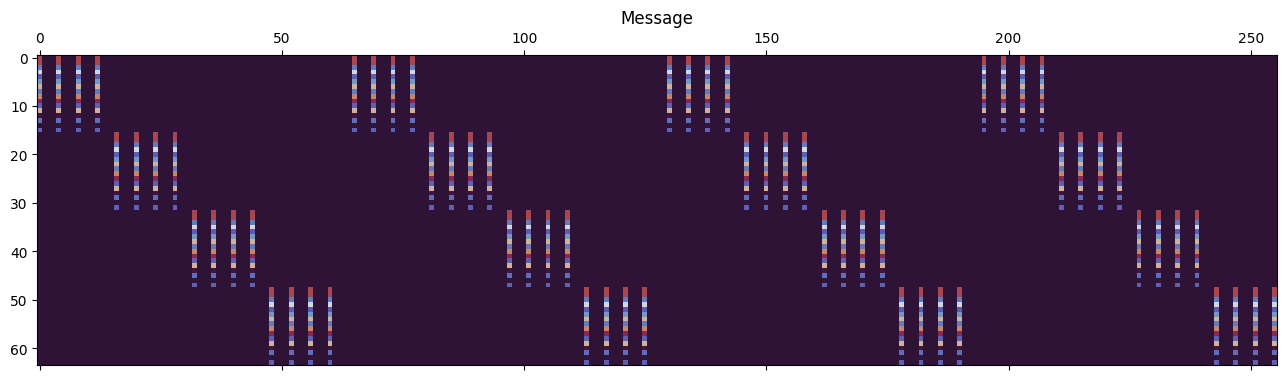

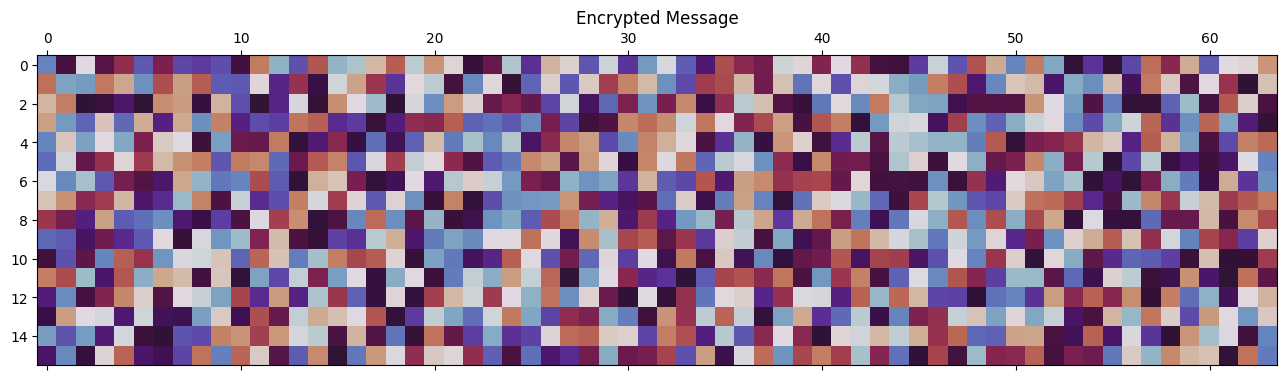

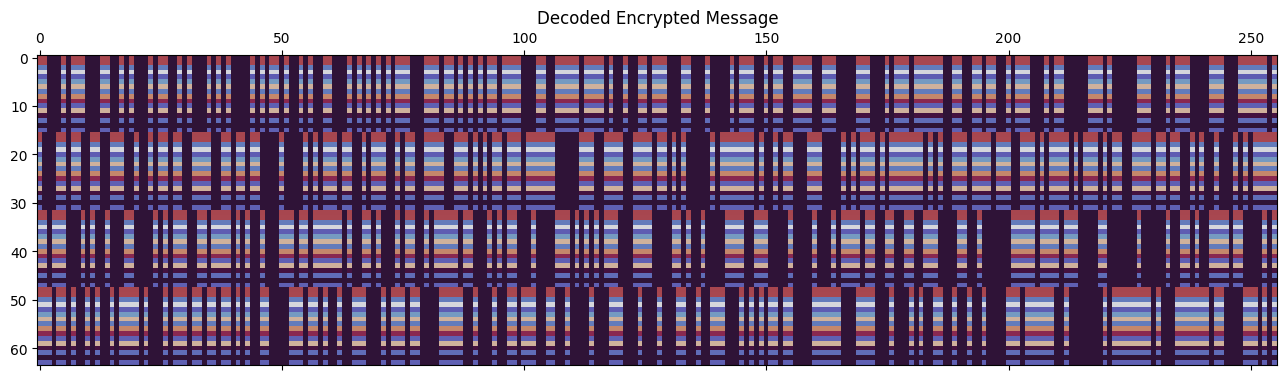

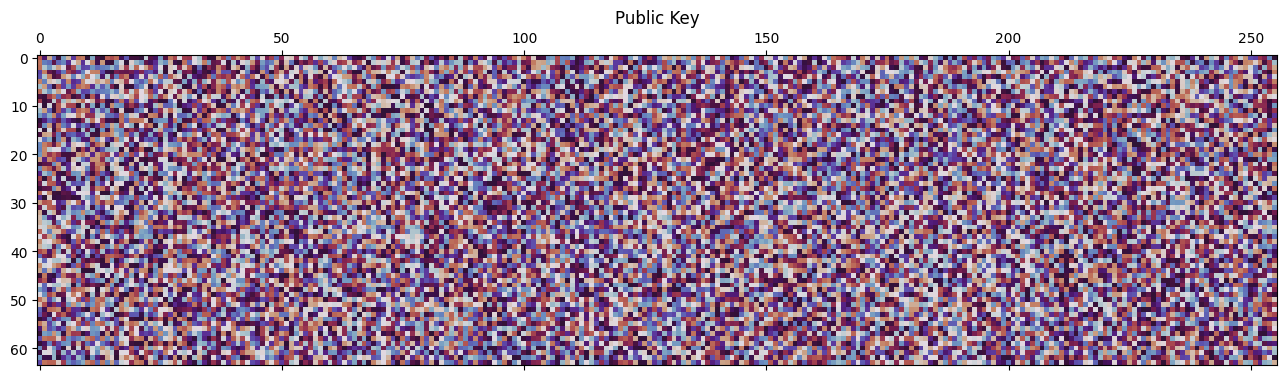

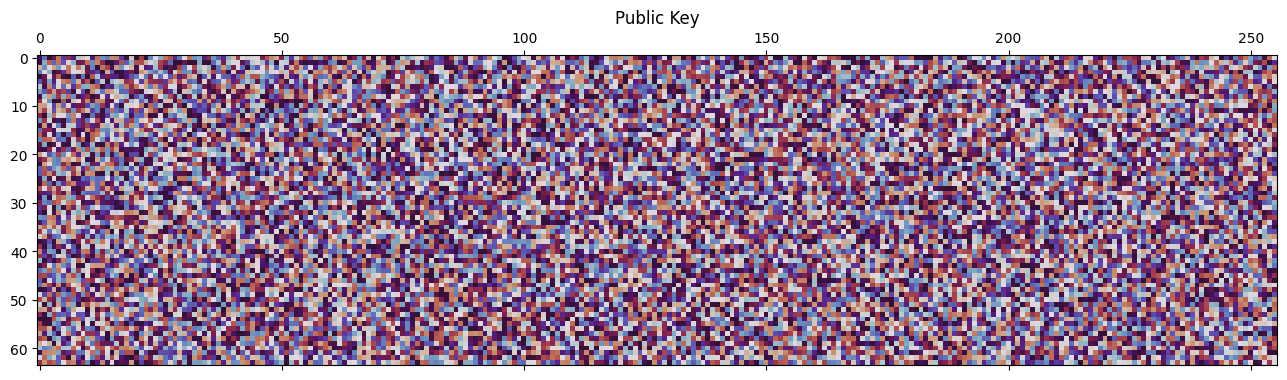

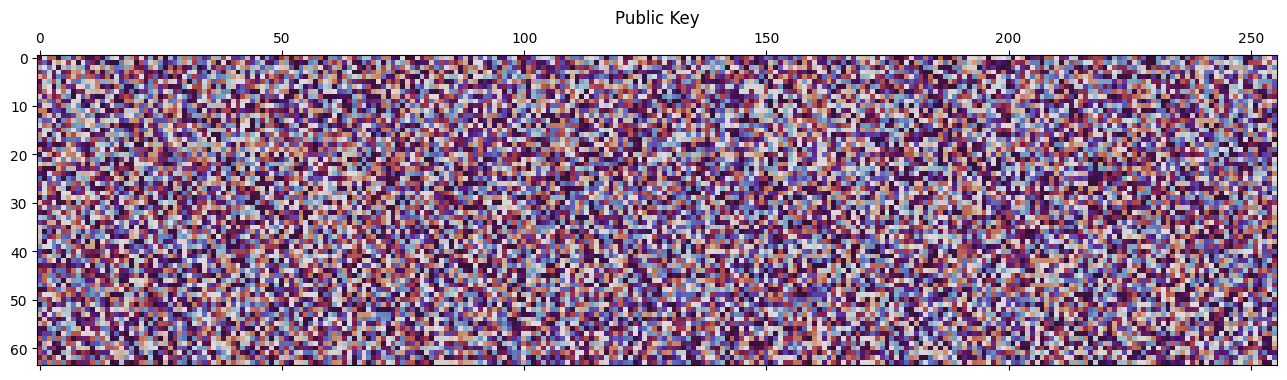

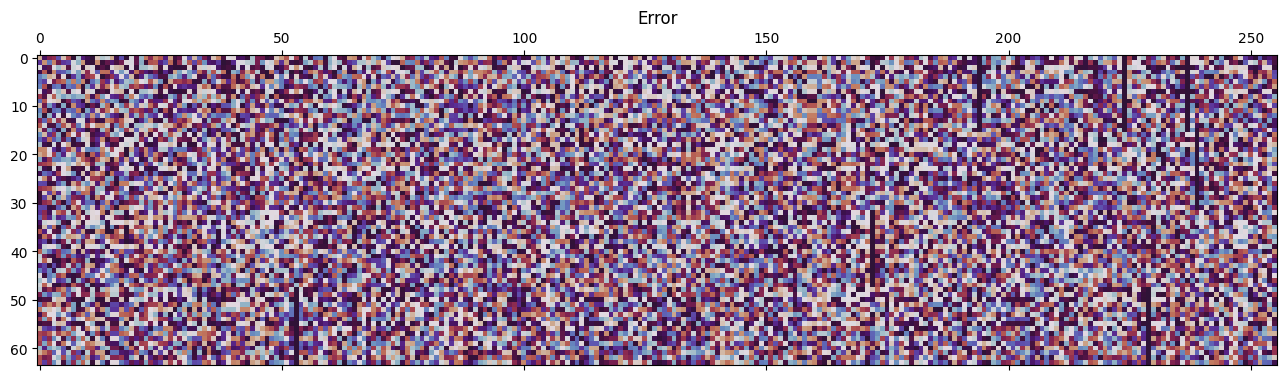

In [3]:
poppy.plot(MU.reshape((-1,k*n)), title = 'Message')
poppy.plot(poppy.ptrace(ct,p).reshape((-1,k)), title = 'Encrypted Message')
poppy.plot(encode(decode(ct)).reshape((-1,k*n)), title = 'Decoded Encrypted Message')
poppy.plot(pk1.reshape((-1,k*n)), title = 'Public Key')
poppy.plot(pk2.reshape((-1,k*n)), title = 'Public Key')
poppy.plot(pk3.reshape((-1,k*n)), title = 'Public Key')
poppy.plot(e.reshape((-1,k*n)), title = 'Error')

In [4]:
%timeit keygen()[0].block_until_ready()
%timeit encrypt(M,ek)[0].block_until_ready()
%timeit decrypt(c,dk)[0].block_until_ready()

2.4 ms ± 672 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.33 ms ± 517 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.13 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
p = 293
n = 12
f = poppy.field(p,n)

print(poppy.ptrace(jax.numpy.tensordot(f.BASIS,f.DUALBASIS, axes = ([2],[1])).swapaxes(1,2),p))

[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]


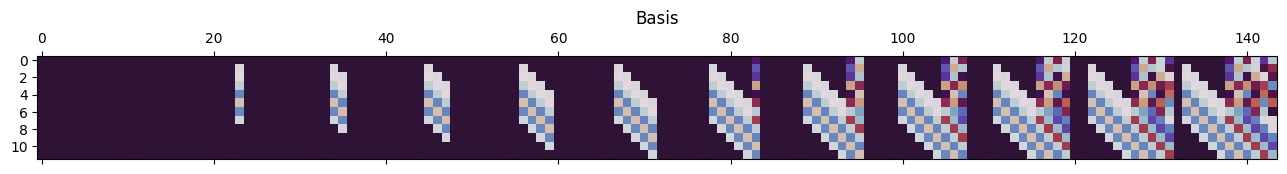

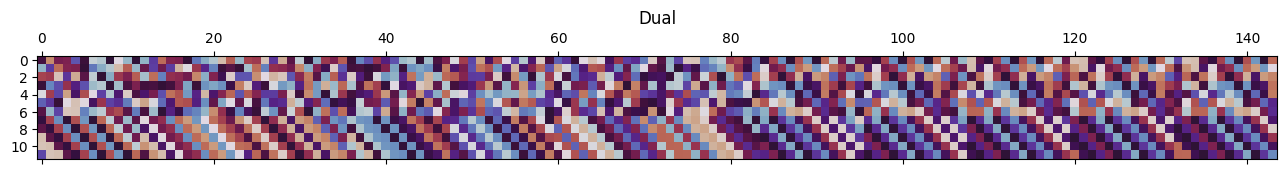

In [6]:
poppy.plot(f.BASIS, title = 'Basis')
poppy.plot(f.DUALBASIS, title = 'Dual')

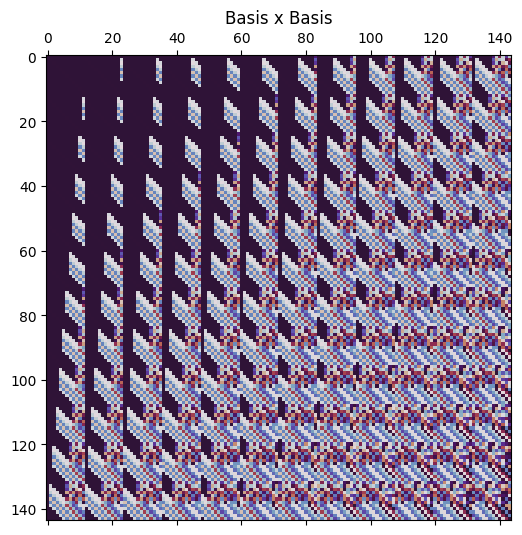

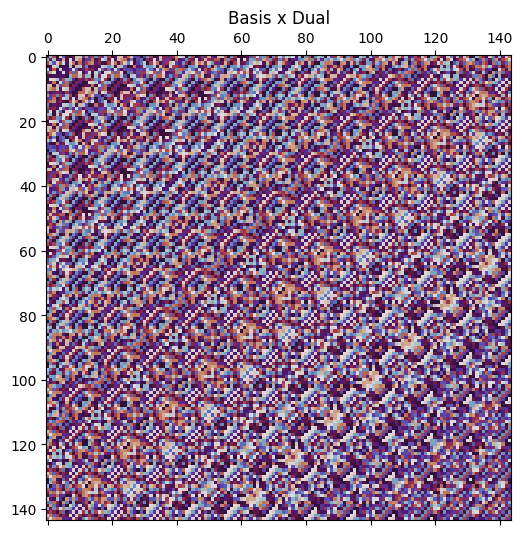

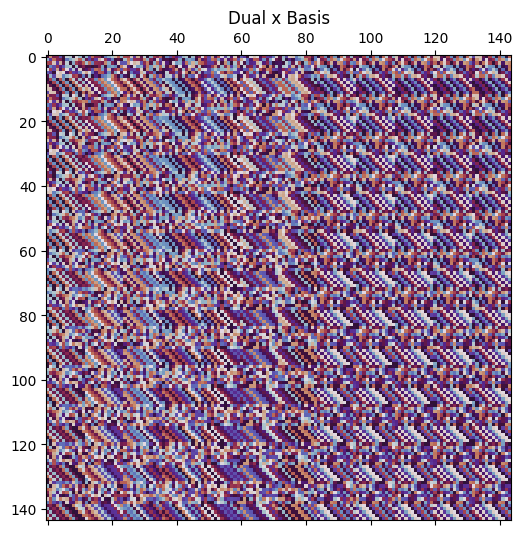

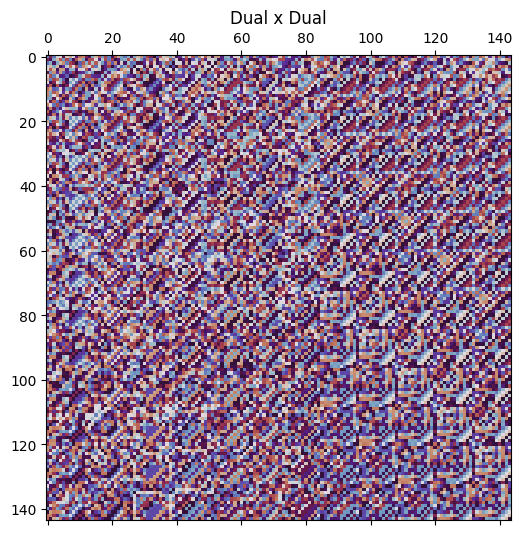

In [7]:
poppy.plot(jax.numpy.tensordot(f.BASIS,f.BASIS, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n))%p, title = 'Basis x Basis')
poppy.plot(jax.numpy.tensordot(f.BASIS,f.DUALBASIS, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n))%p, title = 'Basis x Dual')
poppy.plot(jax.numpy.tensordot(f.DUALBASIS,f.BASIS, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n))%p, title = 'Dual x Basis')
poppy.plot(jax.numpy.tensordot(f.DUALBASIS,f.DUALBASIS, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n))%p, title = 'Dual x Dual')

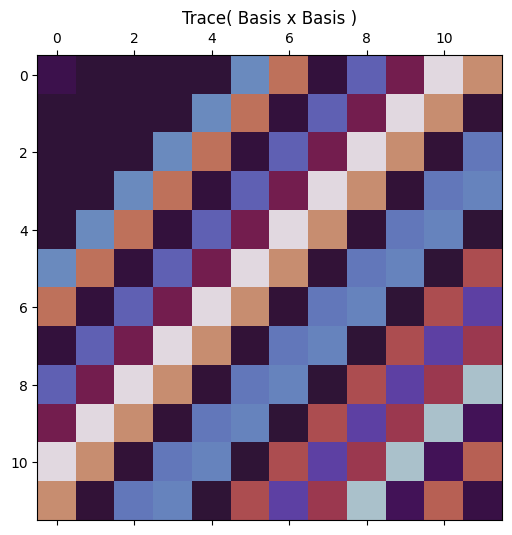

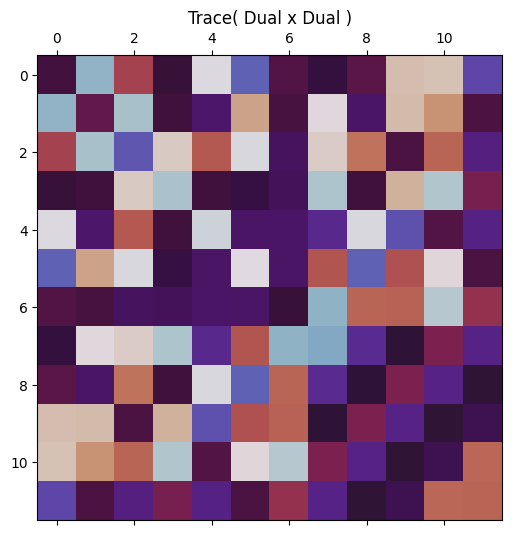

In [8]:
poppy.plot(poppy.ptrace(jax.numpy.tensordot(f.BASIS,f.BASIS, axes = ([2],[1])).swapaxes(1,2)%p,p), title = 'Trace( Basis x Basis )')
poppy.plot(poppy.ptrace(jax.numpy.tensordot(f.DUALBASIS,f.DUALBASIS, axes = ([2],[1])).swapaxes(1,2)%p,p), title = 'Trace( Dual x Dual )')

In [9]:
import hashlib

def G(s):
  return jax.numpy.array(list(hashlib.sha3_512(s).digest()), dtype = jax.numpy.uint8)
def H(s):
  return jax.numpy.array(list(hashlib.sha3_256(s).digest()), dtype = jax.numpy.uint8)
def J(s):
  return jax.numpy.array(list(hashlib.shake_256(s).digest(32)), dtype = jax.numpy.uint8)